<a href="https://colab.research.google.com/github/diyanigam/satelliteimagery/blob/main/cnn_models_rs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

GPU Setup

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: []
Num GPUs: 0


**Loading Dataset**

In [ ]:
data = tfds.load('uc_merced', split='train')
data = tfds.as_numpy(data)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/uc_merced/incomplete.R4B7GJ_2.0.0/uc_merced-train.tfrecord*...:   0%|     …

Dataset uc_merced downloaded and prepared to /root/tensorflow_datasets/uc_merced/2.0.0. Subsequent calls will reuse this data.


**Data Preprocessing**

In [ ]:
x,y = [], []
for i in data:
    img = tf.image.resize(i['image'], [256, 256])
    x.append(img)
    y.append(i['label'])

x = np.array(x)
y = np.array(y)

In [ ]:
x.shape

(2100, 256, 256, 3)

In [ ]:
type(x)

numpy.ndarray

In [ ]:
y

array([10, 20,  8, ...,  2,  5, 20])

**Training-Testing Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

**Model Evaluation function**

In [ ]:
def evaluate_model(name, model, X_test, y_test, history):
    print(name)
    # Predictions
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Loss
    loss = model.evaluate(X_test, y_test)[0]
    print(f"Loss: {loss:.4f}")

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f"Precision: {precision:.4f}")

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"Recall: {recall:.4f}")

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1-Score: {f1:.4f}")

    # Intersection over Union (IoU) / Jaccard Index
    iou = jaccard_score(y_test, y_pred, average='weighted')
    print(f"IoU: {iou:.4f}")

    # Dice Coefficient
    def dice_coefficient(y_test, y_pred):
        intersection = np.sum(y_test * y_pred)
        return (2. * intersection) / (np.sum(y_test) + np.sum(y_pred))

    dice = dice_coefficient(y_test, y_pred)
    print(f"Dice Coefficient: {dice:.4f}")

    # Check EarlyStopping epoch
    stopped_epoch = len(history.history['loss'])  # Last epoch where training stopped
    print(f"Training stopped at epoch: {stopped_epoch}")

    # Training and validation loss plot
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(history.history['loss']) + 1)

    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.axvline(x=stopped_epoch, color='red', linestyle='--', label=f'Early Stopping (Epoch {stopped_epoch})')

    plt.title( name+' Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Learning rate reductions plot
    if 'learning_rate' in history.history:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history['learning_rate'], label='Learning Rate')
        plt.title(name+' Learning Rate Schedule')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.grid()
        plt.legend()
        plt.show()
    else:
        print("No learning rate schedule available in history.")

    # Accuracy Graph
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(name + ' Training and Validation Accuracy')
    plt.show()


# **CNN Model**

In [ ]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu', padding='same', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2),strides=(2,2), padding='same'),
    layers.Dropout(0.25),
    layers.Conv2D(256, (3, 3), strides=(1,1), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2),strides=(2,2), padding='same'),
    layers.Conv2D(512, (3, 3), strides=(1,1), activation='relu', padding='same'),
    # layers.Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    # layers.Conv1D(128, 3, strides=), activation='relu', padding='same'),
    layers.Dense(21, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001)
model.compile(optimizer = Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=24, epochs=200, verbose=1, validation_data=[X_val, y_val], callbacks=[early_stopping, reduce_lr])

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.0465 - loss: 18.8433 - val_accuracy: 0.0595 - val_loss: 2.8855 - learning_rate: 0.0010
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0972 - loss: 2.8444 - val_accuracy: 0.1369 - val_loss: 2.7257 - learning_rate: 0.0010
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1765 - loss: 2.5901 - val_accuracy: 0.1726 - val_loss: 2.5515 - learning_rate: 0.0010
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1851 - loss: 2.5819 - val_accuracy: 0.1726 - val_loss: 2.7340 - learning_rate: 0.0010
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2469 - loss: 2.3030 - val_accuracy: 0.2024 - val_loss: 2.5147 - learning_rate: 0.0010
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3450 - loss: 2.0620 - val_accuracy: 0.3333 - val_loss: 2.0817 - learning_rate: 0.0010
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4050 - loss: 1.8837 -

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7187 - loss: 0.9335
Test accuracy: 0.7309523820877075


**Evaluation Graphs**

CNN_trad
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Accuracy: 0.7310
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7187 - loss: 0.9335
Loss: 0.8724
Precision: 0.7616
Recall: 0.7310
F1-Score: 0.7378
IoU: 0.6139
Dice Coefficient: 12.6490
Training stopped at epoch: 56


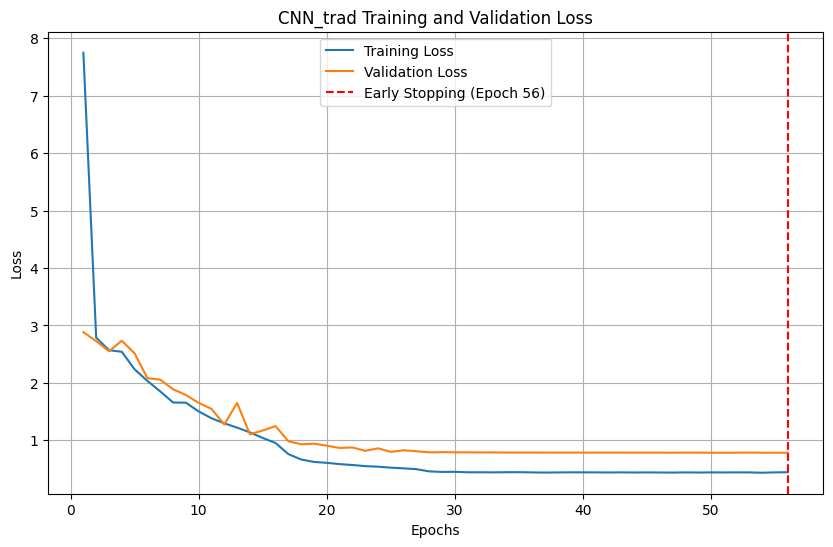

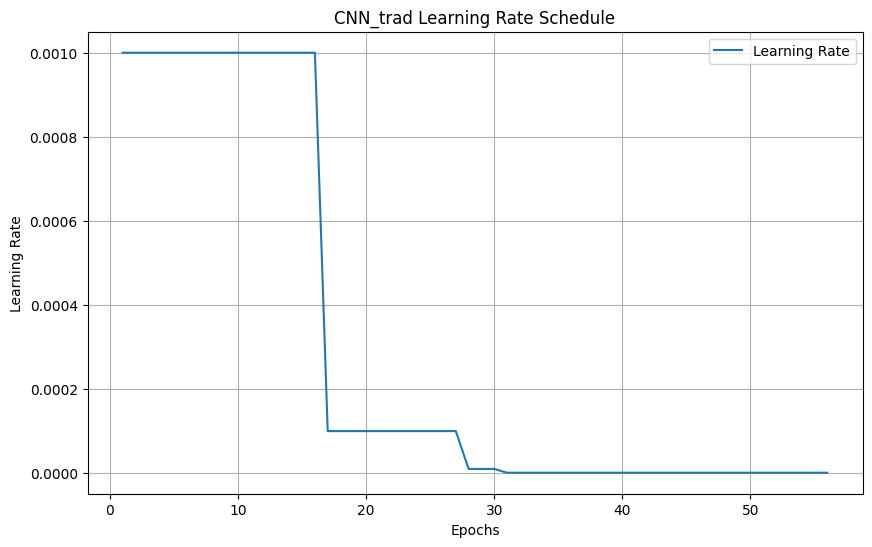

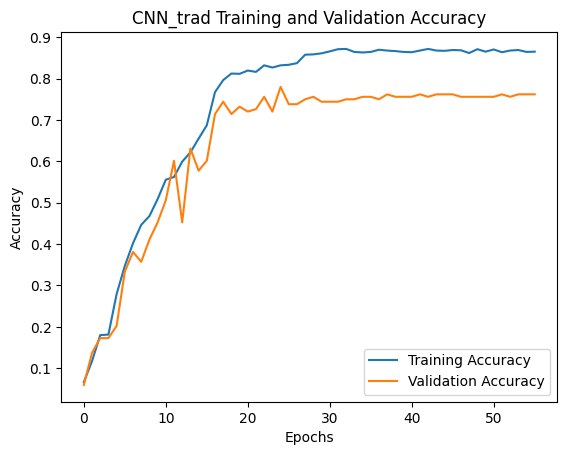

In [ ]:
evaluate_model("CNN_trad", model, X_test, y_test, history)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 21)                  │          10,773 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,685,249 (17.87 MB)

 Trainable params: 1,561,749 (5.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,123,500 (11.92 MB)

# **ResNet 50**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

In [ ]:
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(256,256,3))
for layer in resnet_50.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
x = resnet_50.output
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
predictions = layers.Dense(21, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
model.compile(optimizer = Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=24, epochs=200, verbose=1, validation_data=[X_val, y_val], callbacks=[early_stopping, reduce_lr])

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.3223 - loss: 2.5551 - val_accuracy: 0.8571 - val_loss: 0.4244 - learning_rate: 0.0010
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9132 - loss: 0.2492 - val_accuracy: 0.8690 - val_loss: 0.4282 - learning_rate: 0.0010
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9744 - loss: 0.0837 - val_accuracy: 0.9107 - val_loss: 0.2407 - learning_rate: 0.0010
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9877 - loss: 0.0411 - val_accuracy: 0.9405 - val_loss: 0.2407 - learning_rate: 0.0010
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9970 - loss: 0.0192 - val_accuracy: 0.9226 - val_loss: 0.2541 - learning_rate: 0.0010
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9985 - loss: 0.0063 - val_accuracy: 0.9464 - val_loss: 0.1943 - learning_rate: 1.0000e-04
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0

**Evaluation**

In [ ]:
## time = 54sec

ResNet_50
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 657ms/step
Accuracy: 0.9286
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.9277 - loss: 0.2180
Loss: 0.2400
Precision: 0.9339
Recall: 0.9286
F1-Score: 0.9285
IoU: 0.8717
Dice Coefficient: 13.3521
Training stopped at epoch: 24


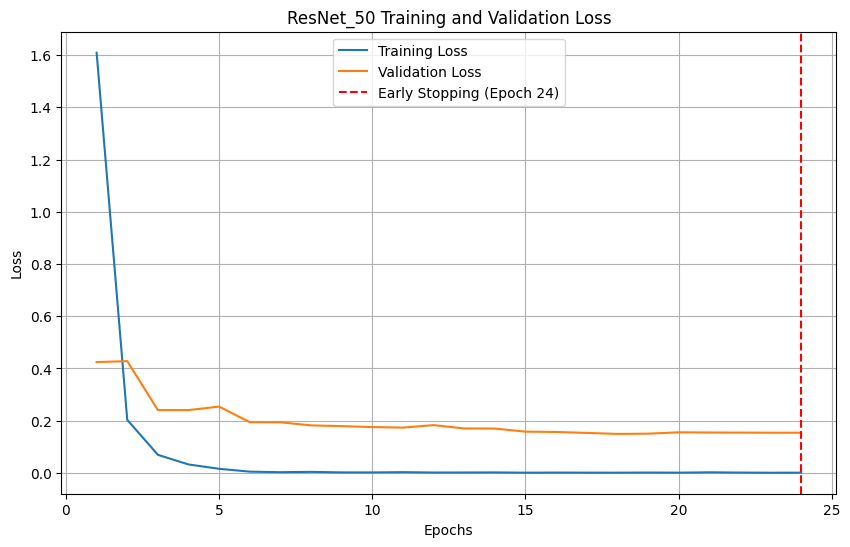

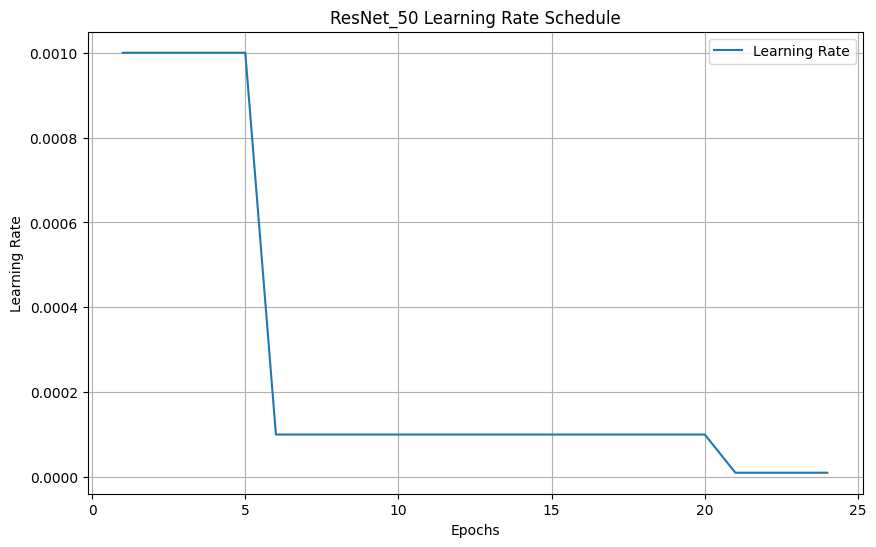

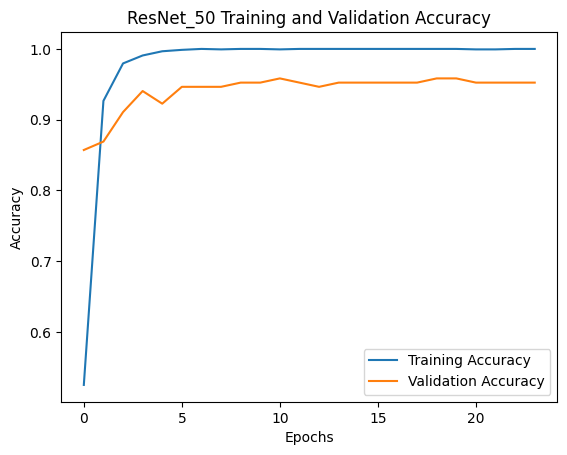

In [ ]:
evaluate_model("ResNet_50", model, X_test, y_test, history)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,657,409 (94.06 MB)

 Trainable params: 356,565 (1.36 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 713,132 (2.72 MB)

# **ResNet101**

In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model

In [ ]:
resnet_101 = ResNet101(include_top=False, weights='imagenet', input_shape=(256,256,3))
for layer in resnet_101.layers:
    layer.trainable = False

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
x = resnet_101.output
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
predictions = layers.Dense(21, activation='softmax')(x)
model = Model(inputs = resnet_101.input, outputs = predictions)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
model.compile(optimizer = Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=12, epochs=50, verbose=1, validation_data=[X_val, y_val], callbacks=[early_stopping, reduce_lr])

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step - accuracy: 0.3469 - loss: 2.5073 - val_accuracy: 0.8333 - val_loss: 0.4306 - learning_rate: 0.0010
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9024 - loss: 0.3072 - val_accuracy: 0.8333 - val_loss: 0.4113 - learning_rate: 0.0010
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9621 - loss: 0.1154 - val_accuracy: 0.8929 - val_loss: 0.4139 - learning_rate: 0.0010
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9838 - loss: 0.0508 - val_accuracy: 0.8631 - val_loss: 0.6274 - learning_rate: 0.0010
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9618 - loss: 0.1252 - val_accuracy: 0.8810 - val_loss: 0.5790 - learning_rate: 0.0010
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9795 - loss: 0.0580 - val_accuracy: 0.9345 - val_loss: 0.2491 - learning_rate: 1.0000e-04
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9935 - lo

In [ ]:
## time = 1m18sec

**Evaluation Graphs**

ResNet_101
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 819ms/step
Accuracy: 0.9333
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.9329 - loss: 0.2301
Loss: 0.2561
Precision: 0.9372
Recall: 0.9333
F1-Score: 0.9326
IoU: 0.8821
Dice Coefficient: 13.4307
Training stopped at epoch: 17


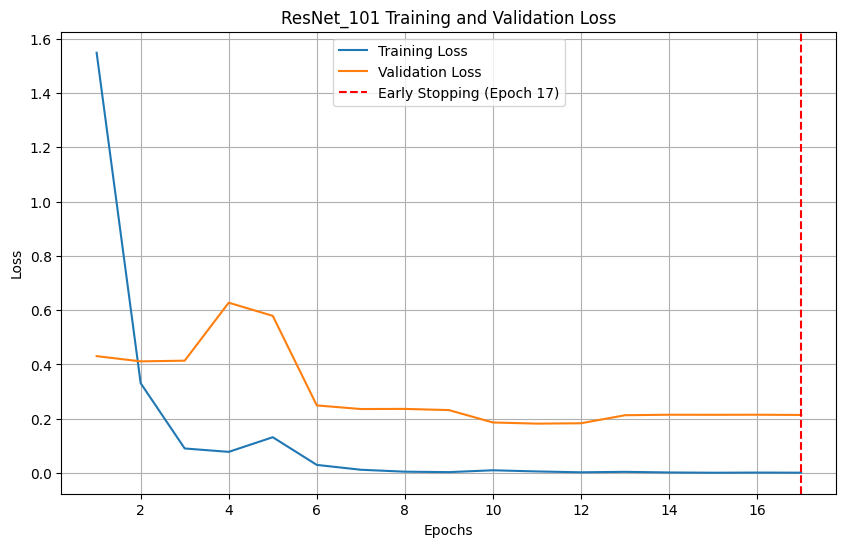

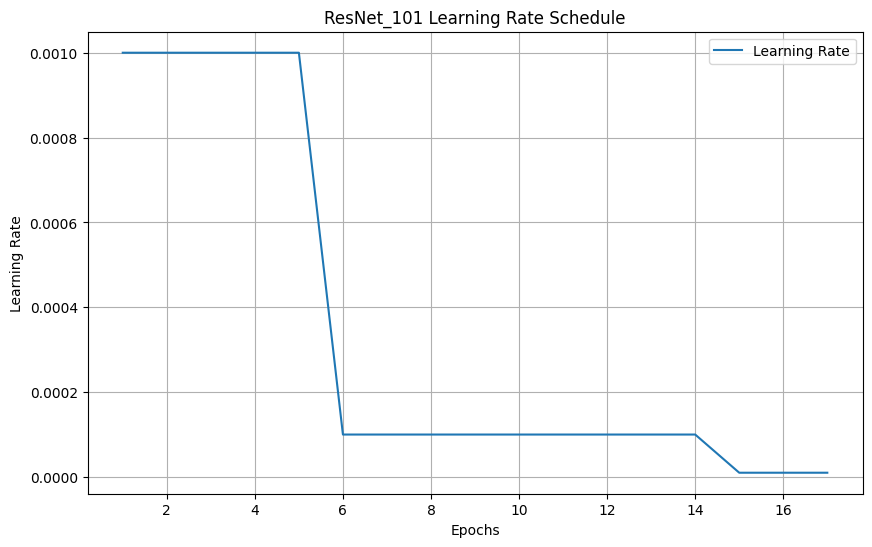

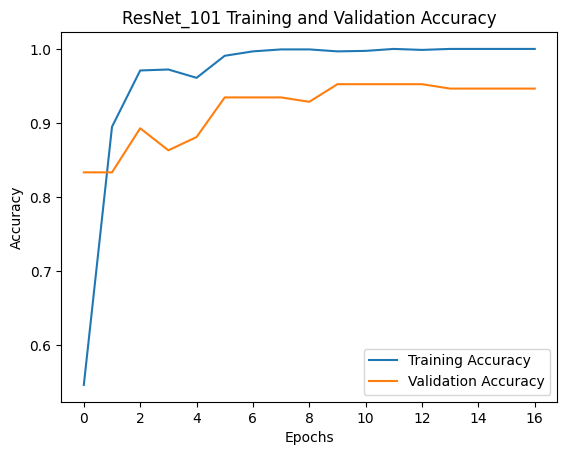

In [ ]:
evaluate_model("ResNet_101", model, X_test, y_test, history)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 44,613,377 (170.19 MB)

 Trainable params: 651,733 (2.49 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

 Optimizer params: 1,303,468 (4.97 MB)

# **Inception V3**

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

In [ ]:
inception_v3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(256,256,3))
for layer in inception_v3.layers:
    layer.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = inception_v3.output
x = layers.Flatten()(x)
x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(21, activation='softmax')(x)
model = Model(inputs = inception_v3.input, outputs = predictions)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.000001)
model.compile(optimizer = Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=10, epochs=200, verbose=1, validation_data=[X_val, y_val], callbacks=[early_stopping, reduce_lr])

Epoch 1/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 140ms/step - accuracy: 0.2399 - loss: 83.0372 - val_accuracy: 0.3929 - val_loss: 90.1844 - learning_rate: 0.0010
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5913 - loss: 44.1525 - val_accuracy: 0.3988 - val_loss: 72.0996 - learning_rate: 0.0010
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6900 - loss: 30.0821 - val_accuracy: 0.4464 - val_loss: 62.8797 - learning_rate: 0.0010
Epoch 4/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7154 - loss: 21.9722 - val_accuracy: 0.4286 - val_loss: 49.3024 - learning_rate: 0.0010
Epoch 5/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8315 - loss: 11.9639 - val_accuracy: 0.4643 - val_loss: 58.9926 - learning_rate: 0.0010
Epoch 6/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8306 - loss: 15.2671 - val_accuracy: 0.5000 - val_loss: 55.3182 - learning_rate: 0.0010
Epoch 7/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accura

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 439ms/step - accuracy: 0.5314 - loss: 64.0233
Test accuracy: 0.5476190447807312


**Evaluation Graphs**

Inception_V3
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 402ms/step
Accuracy: 0.5476
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5314 - loss: 64.0233
Loss: 53.3309
Precision: 0.5652
Recall: 0.5476
F1-Score: 0.5501
IoU: 0.4058
Dice Coefficient: 11.9877
Training stopped at epoch: 38


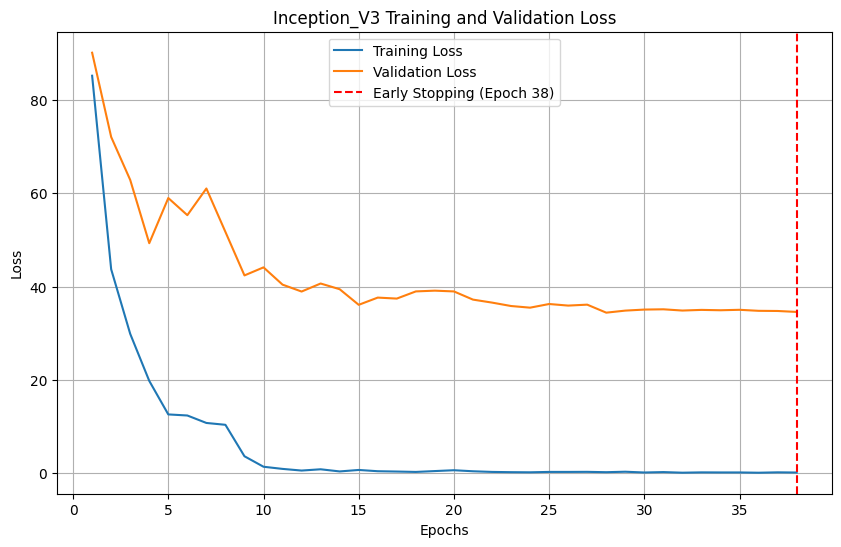

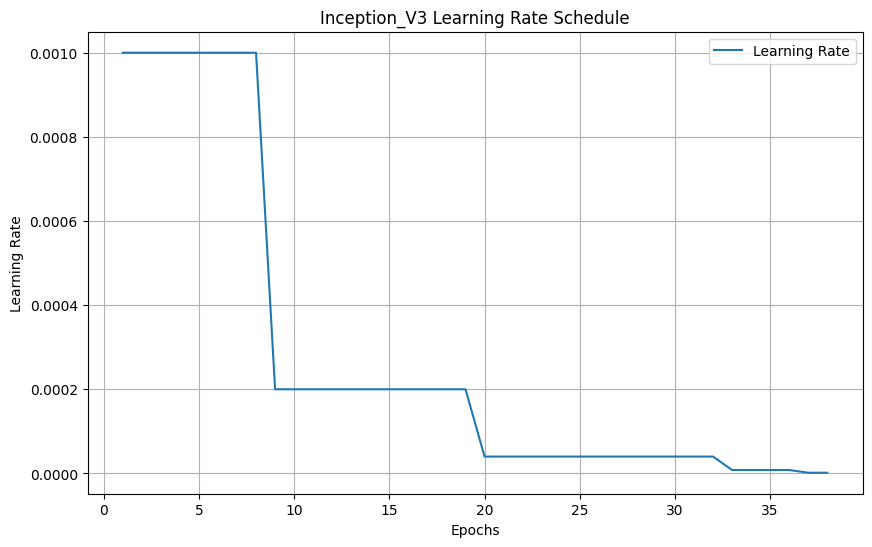

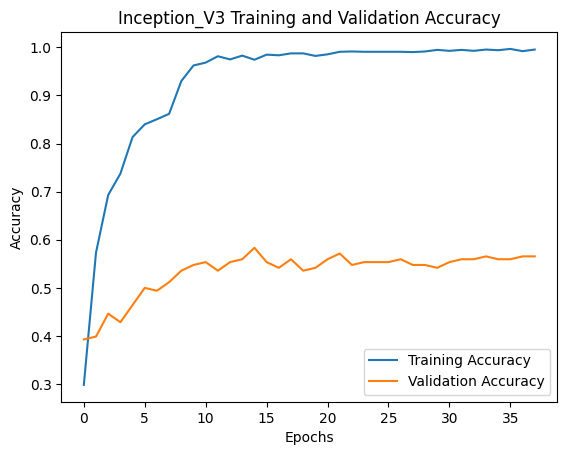

In [ ]:
evaluate_model("Inception_V3", model, X_test, y_test, history)

In [ ]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 127, 127, 32)   │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 127, 127, 32)   │             96 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 127, 127, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 125, 125, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 125, 125, 32)   │             96 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 125, 125, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 125, 125, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 125, 125, 64)   │            192 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 125, 125, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 62, 62, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 62, 62, 80)     │            240 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 62, 62, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 60, 60, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 60, 60, 192)    │            576 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 248,952,673 (949.68 MB)

 Trainable params: 75,667,477 (288.65 MB)

 Non-trainable params: 21,950,240 (83.73 MB)

 Optimizer params: 151,334,956 (577.30 MB)

# **VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model = Sequential()
model.add(base_model)
#model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(21, activation='softmax'))

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=12, min_lr=0.000001)
model.compile(optimizer = Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=8, epochs=100, verbose=1, validation_data=[X_val, y_val], callbacks=[reduce_lr])

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.0535 - loss: 4.6711 - val_accuracy: 0.0298 - val_loss: 3.0523 - learning_rate: 1.0000e-04
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0579 - loss: 3.0641 - val_accuracy: 0.0298 - val_loss: 3.0626 - learning_rate: 1.0000e-04
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0676 - loss: 3.0211 - val_accuracy: 0.0357 - val_loss: 3.0487 - learning_rate: 1.0000e-04
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0575 - loss: 3.0328 - val_accuracy: 0.0357 - val_loss: 3.0451 - learning_rate: 1.0000e-04
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0619 - loss: 3.0329 - val_accuracy: 0.0357 - val_loss: 3.0396 - learning_rate: 1.0000e-04
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0612 - loss: 3.0286 - val_accuracy: 0.0417 - val_loss: 3.0335 - learning_rate: 1.0000e-04
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - ac

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.8491 - loss: 1.3343
Test accuracy: 0.8309524059295654


VGG16
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step
Accuracy: 0.8310
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8491 - loss: 1.3343
Loss: 1.4025
Precision: 0.8477
Recall: 0.8310
F1-Score: 0.8282
IoU: 0.7282
Dice Coefficient: 13.0543
Training stopped at epoch: 100


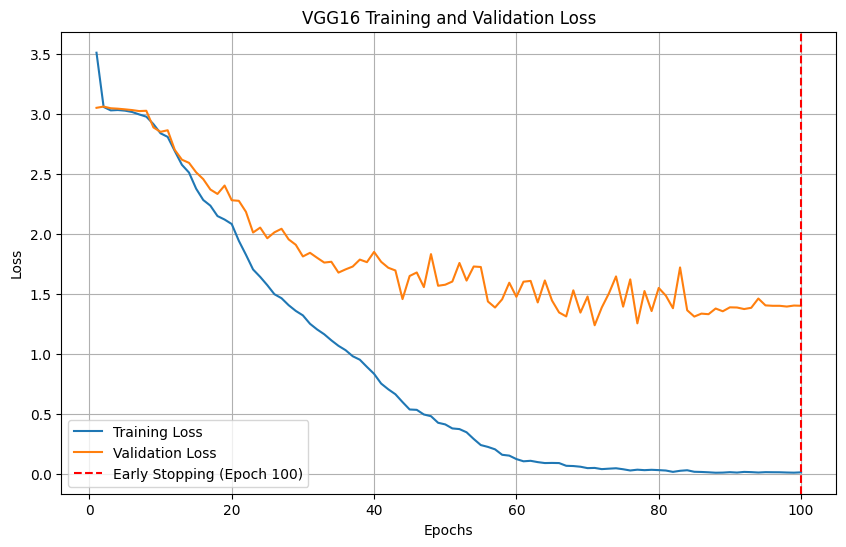

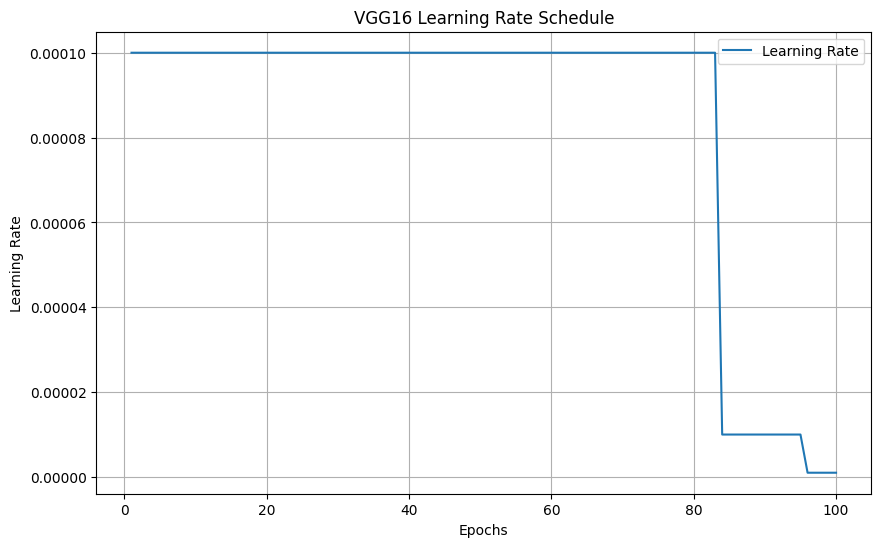

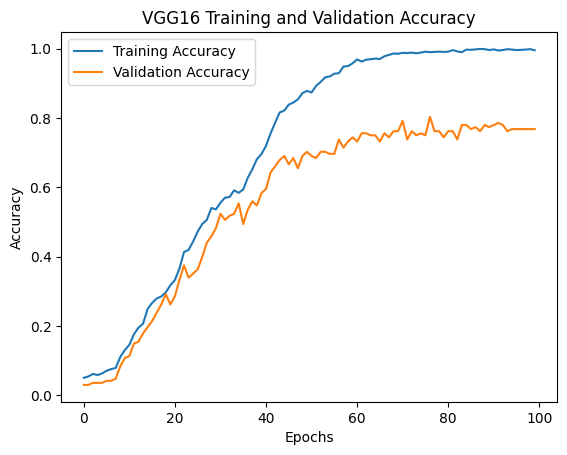

In [ ]:
evaluate_model("VGG16", model, X_test, y_test, history)

In [ ]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 8, 8, 256)           │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 8, 8, 64)            │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 16)                  │          65,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 21)                  │             357 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,355,745 (58.58 MB)

 Trainable params: 213,685 (834.71 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 427,372 (1.63 MB)

# **Xception**

**Data Preprocessing**

In [ ]:
x,y = [], []
for i in data:
    img = tf.image.resize(i['image'], [299, 299])
    x.append(img)
    y.append(i['label'])

x = np.array(x)
y = np.array(y)

**Training-Testing Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

xception = Xception(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
for layer in xception.layers:
    layer.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = xception.output
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Flatten()(x)
predictions = Dense(21, activation='softmax')(x)
model = Model(inputs=xception.input, outputs=predictions)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=14)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
model.compile(optimizer = Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=6, epochs=50, verbose=1, validation_data=[X_val, y_val], callbacks=[early_stopping, reduce_lr])

Epoch 1/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.1357 - loss: 5.8983 - val_accuracy: 0.2560 - val_loss: 2.3400 - learning_rate: 0.0010
Epoch 2/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3060 - loss: 2.2631 - val_accuracy: 0.3393 - val_loss: 2.0880 - learning_rate: 0.0010
Epoch 3/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4027 - loss: 1.9628 - val_accuracy: 0.3869 - val_loss: 2.0751 - learning_rate: 0.0010
Epoch 4/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5165 - loss: 1.5808 - val_accuracy: 0.4345 - val_loss: 1.8394 - learning_rate: 0.0010
Epoch 5/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5437 - loss: 1.4341 - val_accuracy: 0.4167 - val_loss: 1.8402 - learning_rate: 0.0010
Epoch 6/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5956 - loss: 1.3163 - val_accuracy: 0.4405 - val_loss: 1.8385 - learning_rate: 0.0010
Epoch 7/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6470 - loss: 1

In [ ]:
##time = 1m19sec

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.5343 - loss: 2.5672
Test accuracy: 0.5357142686843872


Xception
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step
Accuracy: 0.5357
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5343 - loss: 2.5672
Loss: 2.4954
Precision: 0.5510
Recall: 0.5357
F1-Score: 0.5371
IoU: 0.4035
Dice Coefficient: 11.6281
Training stopped at epoch: 23


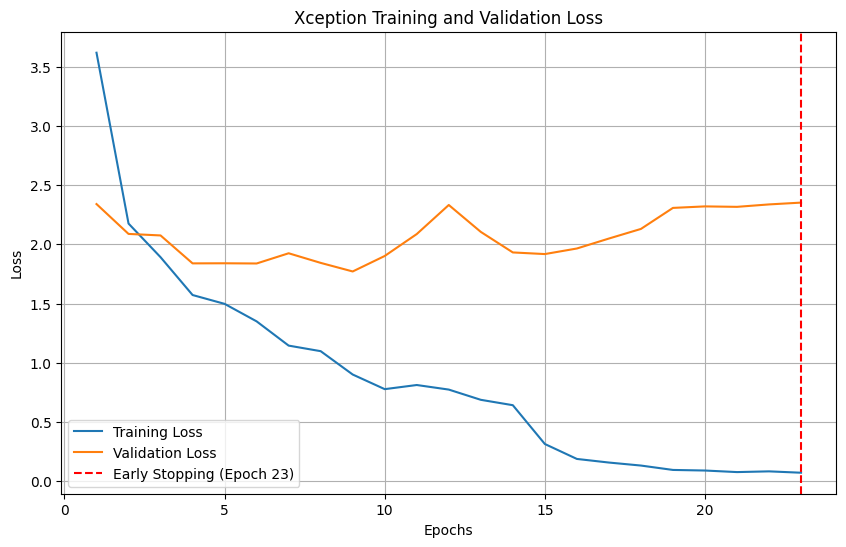

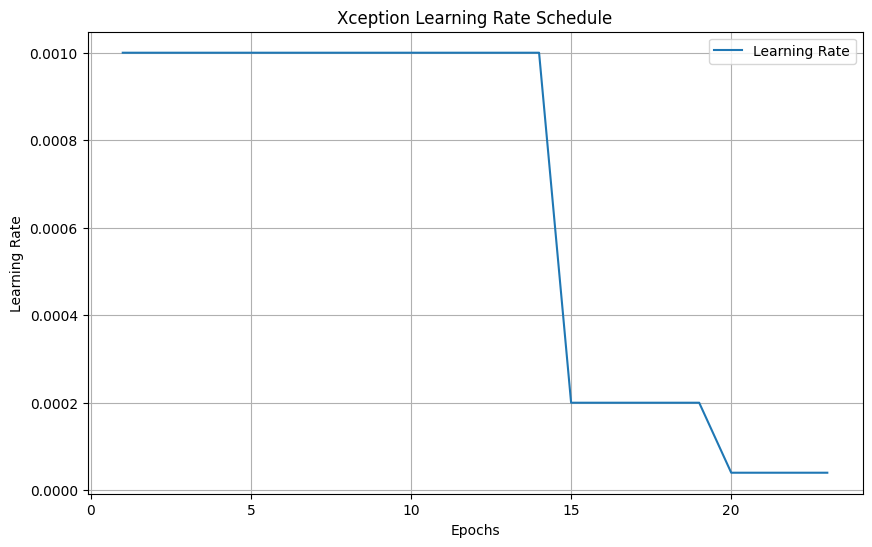

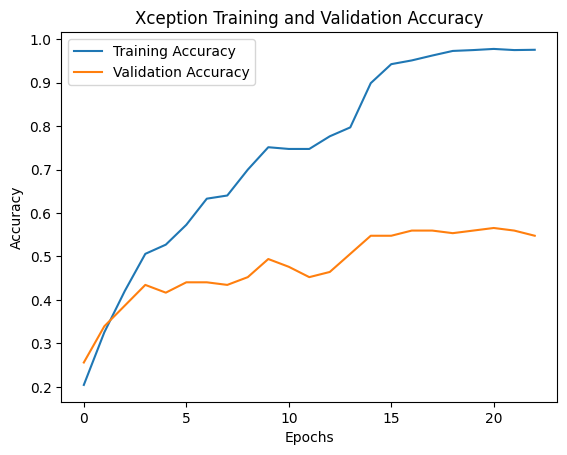

In [ ]:
evaluate_model("Xception", model, X_test, y_test, history)

In [ ]:
model.summary()

Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21            │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,930,505 (83.66 MB)

 Trainable params: 356,341 (1.36 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 712,684 (2.72 MB)